# Wstęp
Zadanie 6 stanowi wprowadzenie w tematykę *data augmentation*. Ze względu na złożonośc modeli głębokich, zwykle wymagają one bardzo dużych zbiorów danych do dobrego wyuczenia. Jednym ze sposobów na skalowanie ilości dostępnych danych są metody tzw. augmentacji - przekształcenia na danych które mamy, aby utworzyć nowe przykłady o znanych etykietach. Pod koniec zadania wprowadzona jest również koncepcja *skip connections*, będących istotnym elementem współczesnych architektur konwolucyjnych i nie tylko.

# Cel ćwiczenia

Celem ćwiczenia jest zapoznanie się z

*    koncepcją augmentacji danych
*    implementacją metod augmentacji danych obrazowych w torch.transforms
*    koncepcją augmentacji niezależnej od dziedziny
*    modelami sieci głębokich ze skip connections

# Augmentacja danych obrazowych

W pierwszej kolejności zapoznajmy się z funkcjonalnością augmentacji danych obrazowych. W pytorch funkcjonalność ta realizowana jest przez transformacje wykonywane na obrazach przez `torchvision.transforms`.

Transformacje które typowo wykorzystuje się w augmentacji to standardowe przekształcenia afiniczne obrazu - rotacje, dobicia, skalowanie. Oczywiście, pownniśmy dobierać transformacje z takich, po których rzeczywiście oczekujemy inwariancji - przekształcony obraz będziemy podawać do sieci z tą samą etykietą. Przykładowo, na zbiorze odręcznie pisanych cyfr MNIST ograniczymy zakres obrotów czy wykorzystanie odbicia w osi poziomej, jako że niechcemy pomylić 5 z 2 czy 6 z 9.

Zapoznaj się z dokumentacją transforms tutaj:

https://pytorch.org/vision/stable/transforms.html

Kod poniżej wczytuje CIFAR 10 i pokazuje wyniki przykładowej augmentacji - losowej rotacji o kąt -30 do 30 stopni.

Using device: mps
Files already downloaded and verified


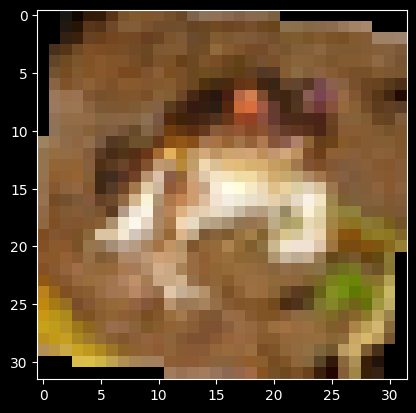

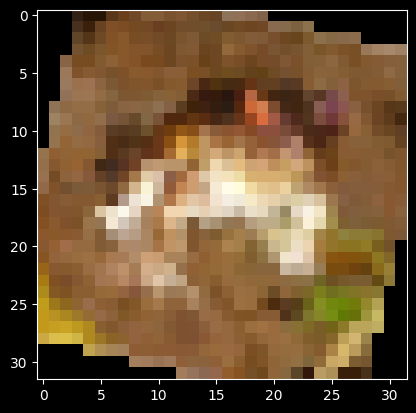

In [1]:
import torch
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import torchvision

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

def plot_results(results):
    num_rows = len(results)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 5 * len(results)))
    if num_rows == 1:
        axes = [axes]
    for ax, (key, values) in zip(axes, results.items()):

        epochs = range(1, len(values['train_loss']) + 1)

        ax[0].plot(epochs, [x.item() for x in values['train_loss']], label='Train Loss')
        ax[0].plot(epochs, [x.item() for x in values['test_loss']], label='Test Loss')
        ax[0].set_title(f"{key} Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        ax[1].plot(epochs, [x.item() for x in values['train_acc']], label='Train Accuracy')
        ax[1].plot(epochs, [x.item() for x in values['test_acc']], label='Test Accuracy')
        ax[1].set_title(f"{key} Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend()

    plt.tight_layout()
    plt.show()

transform = transforms.Compose([
    transforms.RandomRotation(30),                        
    transforms.ToTensor()
])

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
img, label = train_ds[0]

plt.imshow(img.permute(1,2,0))
plt.show()

img, label = train_ds[0]

plt.imshow(img.permute(1,2,0))
plt.show()

Widzimy tutaj kolejny potencjalny problem z augmentacjami: ze względu na konieczność utrzymania stałego kształtu wejścia, augmentacje mogą wprowadzać artefakty takie jak czarne fragmenty na krawędziach obrazu czy aliasing wynikający z niskiej rozdzielczości.

Poniżej kod pomocniczy z laboratorium 3, można zastąpić go własną implementacją pętli uczącej uwzględniającej ulepszenia wykonane na laboratoriach 4 i 5. W zadaniach poniżej wystarczy porównać końcowy wynik uczenia, nie jest wymagane wyrysowywanie pełnych krzywych w tensorboard niemniej mogą one pomóc w analizie otrzymanych wyników.

In [2]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.to(device))
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.to(device)).sum()
        correct += count_correct(y_pred, y_batch.to(device))
        # czyszczenie cache
        torch.mps.empty_cache()
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader,
    test_dl: DataLoader,
    epochs: int,
    patience: int = 3
):
    stop_train: int = 0
    loss_prev: float = float("inf")
    save_obj = None

    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }

    model.train()

    for epoch in range(epochs):
        for X_batch, y_batch in train_dl:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)             # Uzyskanie pseudoprawdopodobieństw dla próbek z minibatcha
            loss = loss_fn(y_pred, y_batch)     # Policzenie funkcji straty

            loss.backward()                     # Wsteczna propagacja z wyniku funkcji straty - policzenie gradientów i zapisanie ich w tensorach (parametrach)
            optimiser.step()                    # Aktualizacja parametrów modelu przez optymalizator na podstawie gradientów zapisanych w tensorach (parametrach) oraz lr
            optimiser.zero_grad()               # Wyzerowanie gradientów w modelu, alternatywnie można wywołać percepron.zero_grad()

        model.eval()                            # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
        with torch.no_grad():                   # Wstrzymujemy przeliczanie i śledzenie gradientów dla tensorów - w procesie ewaluacji modelu nie chcemy zmian w gradientach
            train_loss, train_acc = validate(model, loss_fn, train_dl)
            test_loss, test_acc = validate(model, loss_fn, test_dl)
    
        if test_loss.item() > loss_prev:
            stop_train += 1
        else:
            stop_train = 0
            loss_prev = test_loss.item()

        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['test_loss'].append(test_loss)
        metrics['test_acc'].append(test_acc)
        print(
            f"Epoch {epoch}: "
            f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
            f"test loss = {test_loss:.3f} (acc: {test_acc:.3f})"
        )

        if stop_train == patience:
            print(f"Interrupting training. No progress occurred during {patience} epochs.")
            break

    model.eval() 
    return metrics

Files already downloaded and verified
Files already downloaded and verified


# Zadanie 1

Wykorzystując klasę ThreeLayerCNN, spróbuj dobrać augmentacje danych tak aby poprawić wyniki względem jej braku na zbiorze CIFAR10.

In [3]:
class ThreeLayerCNN(torch.nn.Module):
  def __init__(self, channels: int, labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("conv_1", 
                          torch.nn.Conv2d(3, channels, 3, padding=1))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("max_pool_1", torch.nn.MaxPool2d(2))
    self.model.add_module("conv_2", 
                          torch.nn.Conv2d(channels, channels, 3, padding=1))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("max_pool_2", torch.nn.MaxPool2d(2))
    self.model.add_module("conv3", 
                          torch.nn.Conv2d(channels, channels, 3, padding=1))
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear", torch.nn.Linear(8*8*channels, 10))
  
  def forward(self, x):
    return self.model(x)

Zaprogramuj eksperyment tak, aby w pętli sprawdzać kolejne potencjalne wersje potoku przetwarzania (różniące się tutaj tylko augmentacją), a na końcu wybrać najlepszą - tak aby możliwe było powtórzenie całego eksperymentu uzasadniającego wybór! Transformacja z augmentacją ma być wywoływana tylko na danych treningowych.

Spróbuj znaleźć również przykład augmentacji pogarszającej wynik w stosunku do bazowego otrzymanego bez augmentacji. Wykorzystaj uczenie na 50 epok i optymalizator Adam z domyślnymi parametrami, bez regularyzacji.

Files already downloaded and verified
Files already downloaded and verified
	Training model without augmentation
Epoch 0: train loss = 0.038 (acc: 0.577), test loss = 0.038 (acc: 0.579)
Epoch 1: train loss = 0.032 (acc: 0.644), test loss = 0.033 (acc: 0.626)
Epoch 2: train loss = 0.031 (acc: 0.651), test loss = 0.033 (acc: 0.632)
Epoch 3: train loss = 0.029 (acc: 0.681), test loss = 0.031 (acc: 0.654)
Epoch 4: train loss = 0.027 (acc: 0.693), test loss = 0.030 (acc: 0.660)
Epoch 5: train loss = 0.026 (acc: 0.713), test loss = 0.029 (acc: 0.679)
Epoch 6: train loss = 0.027 (acc: 0.705), test loss = 0.030 (acc: 0.665)
Epoch 7: train loss = 0.024 (acc: 0.731), test loss = 0.028 (acc: 0.691)
Epoch 8: train loss = 0.024 (acc: 0.728), test loss = 0.029 (acc: 0.684)
Epoch 9: train loss = 0.022 (acc: 0.751), test loss = 0.028 (acc: 0.692)
Epoch 10: train loss = 0.023 (acc: 0.747), test loss = 0.029 (acc: 0.687)
Epoch 11: train loss = 0.022 (acc: 0.758), test loss = 0.028 (acc: 0.693)
Epoch 12:

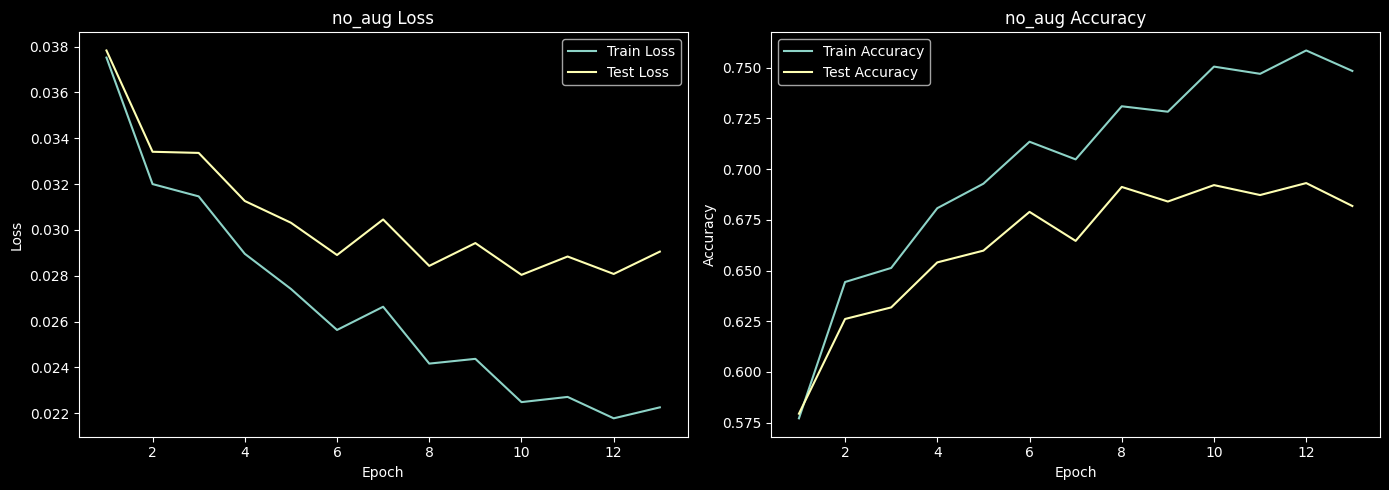

In [4]:
epochs  = 50
results = {}

transform = torchvision.transforms.ToTensor()

model = ThreeLayerCNN(32, 10).to(device)
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters())

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

print(f'\tTraining model without augmentation')
results['no_aug'] = fit(model, optimizer, loss_fn, train_dl, test_dl, epochs)
plot_results(results)

Files already downloaded and verified
Files already downloaded and verified
	Training model with augmentation RandomRotation
Epoch 0: train loss = 0.043 (acc: 0.514), test loss = 0.042 (acc: 0.526)
Epoch 1: train loss = 0.040 (acc: 0.552), test loss = 0.039 (acc: 0.560)
Epoch 2: train loss = 0.039 (acc: 0.564), test loss = 0.037 (acc: 0.583)
Epoch 3: train loss = 0.037 (acc: 0.584), test loss = 0.035 (acc: 0.601)
Epoch 4: train loss = 0.038 (acc: 0.577), test loss = 0.036 (acc: 0.600)
Epoch 5: train loss = 0.036 (acc: 0.600), test loss = 0.034 (acc: 0.626)
Epoch 6: train loss = 0.033 (acc: 0.627), test loss = 0.031 (acc: 0.652)
Epoch 7: train loss = 0.034 (acc: 0.613), test loss = 0.033 (acc: 0.634)
Epoch 8: train loss = 0.034 (acc: 0.616), test loss = 0.032 (acc: 0.637)
Epoch 9: train loss = 0.033 (acc: 0.633), test loss = 0.031 (acc: 0.660)
Epoch 10: train loss = 0.035 (acc: 0.605), test loss = 0.032 (acc: 0.639)
Epoch 11: train loss = 0.032 (acc: 0.644), test loss = 0.030 (acc: 0.66

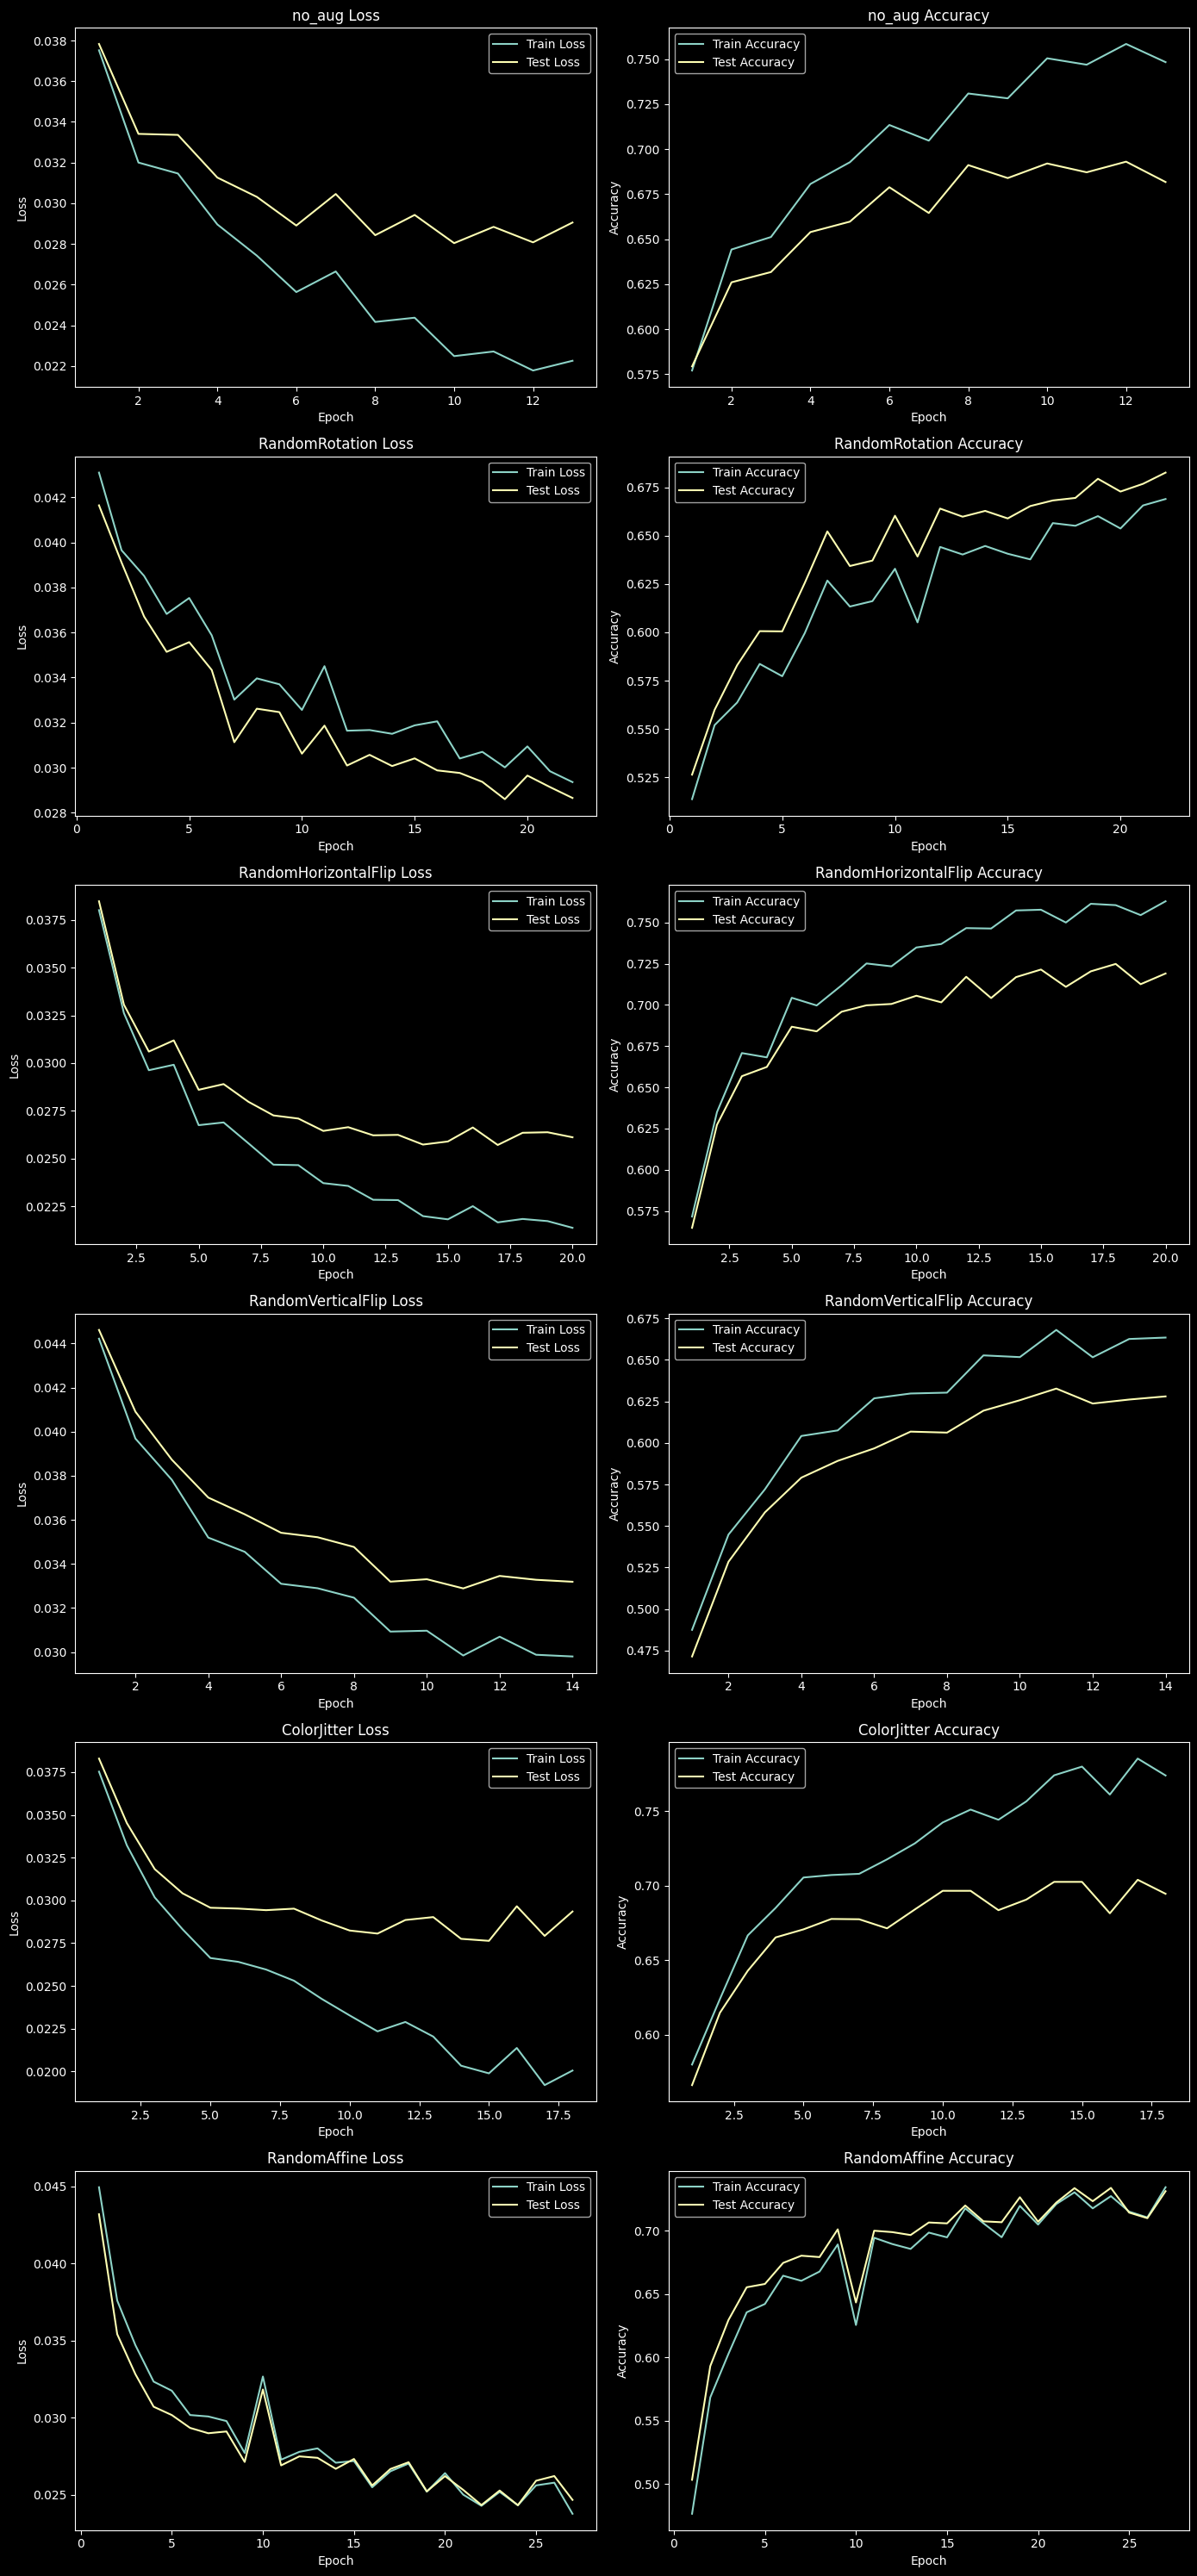

In [5]:
transformations = [
    ("RandomRotation", transforms.RandomRotation(30)),
    ("RandomHorizontalFlip", transforms.RandomHorizontalFlip(p=0.5)),
    ("RandomVerticalFlip", transforms.RandomVerticalFlip(p=0.5)),
    ("ColorJitter", transforms.ColorJitter()),
    ("RandomAffine", transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)))]

for name, t in transformations:
    transform = transforms.Compose([t, transforms.ToTensor()])

    model = ThreeLayerCNN(32, 10).to(device)
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters())

    train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
    test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transforms.ToTensor(), train=False, download=True)

    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
    test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

    print(f'\tTraining model with augmentation {name}')

    results[name] = fit(model, optimizer, loss_fn, train_dl, test_dl, 50)
plot_results(results)

# Mixup - augmentacja ogólna

Augmentacja daje nam spore możliwości w sytuacji, gdy w dziedzinie danych jesteśmy w stanie wskazać przekształcenia na kóre nasz model powinien być **inwariantny** - dla obrazków niewielkie skalowanie czy przesunięcie nie powinno zmieniać wyniku, zaś dla tekstu, podstawianie synonimów może spełniać podobną rolę. Ale w augmentacji danych możliwe jest też podejście niezależne od typu danych, wynikające z obserwacji dotyczących dynamiki uczenia sieci głębokich w ogóle. Ciekawym przykładem jest tu augmentacja Mixup:

https://arxiv.org/abs/1710.09412

Zasada działania mixup jest niezwykle prosta - generujemy nowe przykłady jako **kombinacje liniowe** tych istniejących w zbiorze danych i oczekujemy, że ich etykiety również będą kombinacjami liniowymi etykiet. Innymi słowy, dla pary przykładów z etykietami: $(x_1, y_1)$, $(x_2, y_2)$, możemy wygenerować przykład $(x', y')$:

$x' = \lambda x_1 + (1-\lambda) x_2$

$y' = \lambda y_1 + (1-\lambda) y_2$

Wartość $\lambda$ jest tutaj losowana z rozkładu Beta - animacja podana na https://en.wikipedia.org/wiki/Beta_distribution#Definitions dobrze obrazuje, jak wygląda ten rozkład dla różnych parametryzacji.

# Zadanie 2

Zmodyfikuj funkcję fit tak, aby uczyć zgodnie z podanym wyżej sformułowaniem augmentacji Mixup. Uwaga: będzie to wymagało modyfikacji funkcji kosztu!

In [6]:
from torch.distributions.beta import Beta
import torch.nn.functional as F

def mixup(x, y, alpha=1.0, use_cuda=True):
    '''Zwraca przetworzone batche x i y z zastosowaniem mixup.'''
    if alpha > 0:
        lam = Beta(torch.tensor(alpha), torch.tensor(alpha)).sample()
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(pred, y_a, y_b, lam):
    return lam * F.cross_entropy(pred, y_a) + (1 - lam) * F.cross_entropy(pred, y_b)


def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: str = True,
    patience: int = 3
):
    stop_train: int = 0
    loss_prev: float = float("inf")
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }
    
    for epoch in range(epochs):
        for X_batch, y_batch in tqdm(train_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            X_batch, y_batch_a, y_batch_b, lam = mixup(X_batch, y_batch, 0.8)

            optimiser.zero_grad()
            y_pred = model(X_batch)
            loss = mixup_criterion(y_pred, y_batch_a, y_batch_b, lam)

            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        model.eval()
        with torch.no_grad():
            train_loss, train_acc = validate(model=model, loss_fn=loss_fn, dataloader=train_dl) 
            test_loss, test_acc = validate(model, loss_fn, test_dl)

    
        if test_loss.item() > loss_prev:
            stop_train += 1
        else:
            stop_train = 0
            loss_prev = test_loss.item()

        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['test_loss'].append(test_loss)
        metrics['test_acc'].append(test_acc)
        print(
            f"Epoch {epoch}: "
            f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
            f"test loss = {test_loss:.3f} (acc: {test_acc:.3f})"
        )

        if stop_train == patience:
            print(f"Interrupting training. No progress occurred during {patience} epochs.")
            break

    model.eval() 
    return metrics

Sprawdź, czy uzyskuje ona przewagę nad modelem trenowanym bez augmentacji. 



Files already downloaded and verified
Files already downloaded and verified
	Training model without augmentation


100%|██████████| 1563/1563 [00:08<00:00, 178.11it/s]


Epoch 0: train loss = 0.041 (acc: 0.533), test loss = 0.042 (acc: 0.529)


100%|██████████| 1563/1563 [00:07<00:00, 212.62it/s]


Epoch 1: train loss = 0.036 (acc: 0.620), test loss = 0.037 (acc: 0.604)


100%|██████████| 1563/1563 [00:07<00:00, 218.36it/s]


Epoch 2: train loss = 0.033 (acc: 0.642), test loss = 0.035 (acc: 0.626)


100%|██████████| 1563/1563 [00:07<00:00, 196.30it/s]


Epoch 3: train loss = 0.032 (acc: 0.654), test loss = 0.034 (acc: 0.636)


100%|██████████| 1563/1563 [00:07<00:00, 210.57it/s]


Epoch 4: train loss = 0.031 (acc: 0.677), test loss = 0.033 (acc: 0.656)


100%|██████████| 1563/1563 [00:07<00:00, 211.00it/s]


Epoch 5: train loss = 0.029 (acc: 0.690), test loss = 0.032 (acc: 0.659)


100%|██████████| 1563/1563 [00:07<00:00, 208.33it/s]


Epoch 6: train loss = 0.028 (acc: 0.708), test loss = 0.030 (acc: 0.682)


100%|██████████| 1563/1563 [00:07<00:00, 212.23it/s]


Epoch 7: train loss = 0.029 (acc: 0.700), test loss = 0.031 (acc: 0.668)


100%|██████████| 1563/1563 [00:07<00:00, 210.33it/s]


Epoch 8: train loss = 0.027 (acc: 0.720), test loss = 0.030 (acc: 0.686)


100%|██████████| 1563/1563 [00:07<00:00, 198.19it/s]


Epoch 9: train loss = 0.026 (acc: 0.725), test loss = 0.029 (acc: 0.686)


100%|██████████| 1563/1563 [00:07<00:00, 208.39it/s]


Epoch 10: train loss = 0.027 (acc: 0.726), test loss = 0.030 (acc: 0.687)


100%|██████████| 1563/1563 [00:07<00:00, 210.13it/s]


Epoch 11: train loss = 0.026 (acc: 0.734), test loss = 0.030 (acc: 0.689)


100%|██████████| 1563/1563 [00:07<00:00, 199.05it/s]


Epoch 12: train loss = 0.025 (acc: 0.736), test loss = 0.029 (acc: 0.692)


100%|██████████| 1563/1563 [00:07<00:00, 216.69it/s]


Epoch 13: train loss = 0.025 (acc: 0.746), test loss = 0.029 (acc: 0.698)


100%|██████████| 1563/1563 [00:07<00:00, 211.86it/s]


Epoch 14: train loss = 0.026 (acc: 0.741), test loss = 0.030 (acc: 0.692)


100%|██████████| 1563/1563 [00:07<00:00, 204.43it/s]


Epoch 15: train loss = 0.026 (acc: 0.740), test loss = 0.030 (acc: 0.689)


100%|██████████| 1563/1563 [00:08<00:00, 193.21it/s]


Epoch 16: train loss = 0.025 (acc: 0.751), test loss = 0.029 (acc: 0.700)
Interrupting training. No progress occurred during 3 epochs.


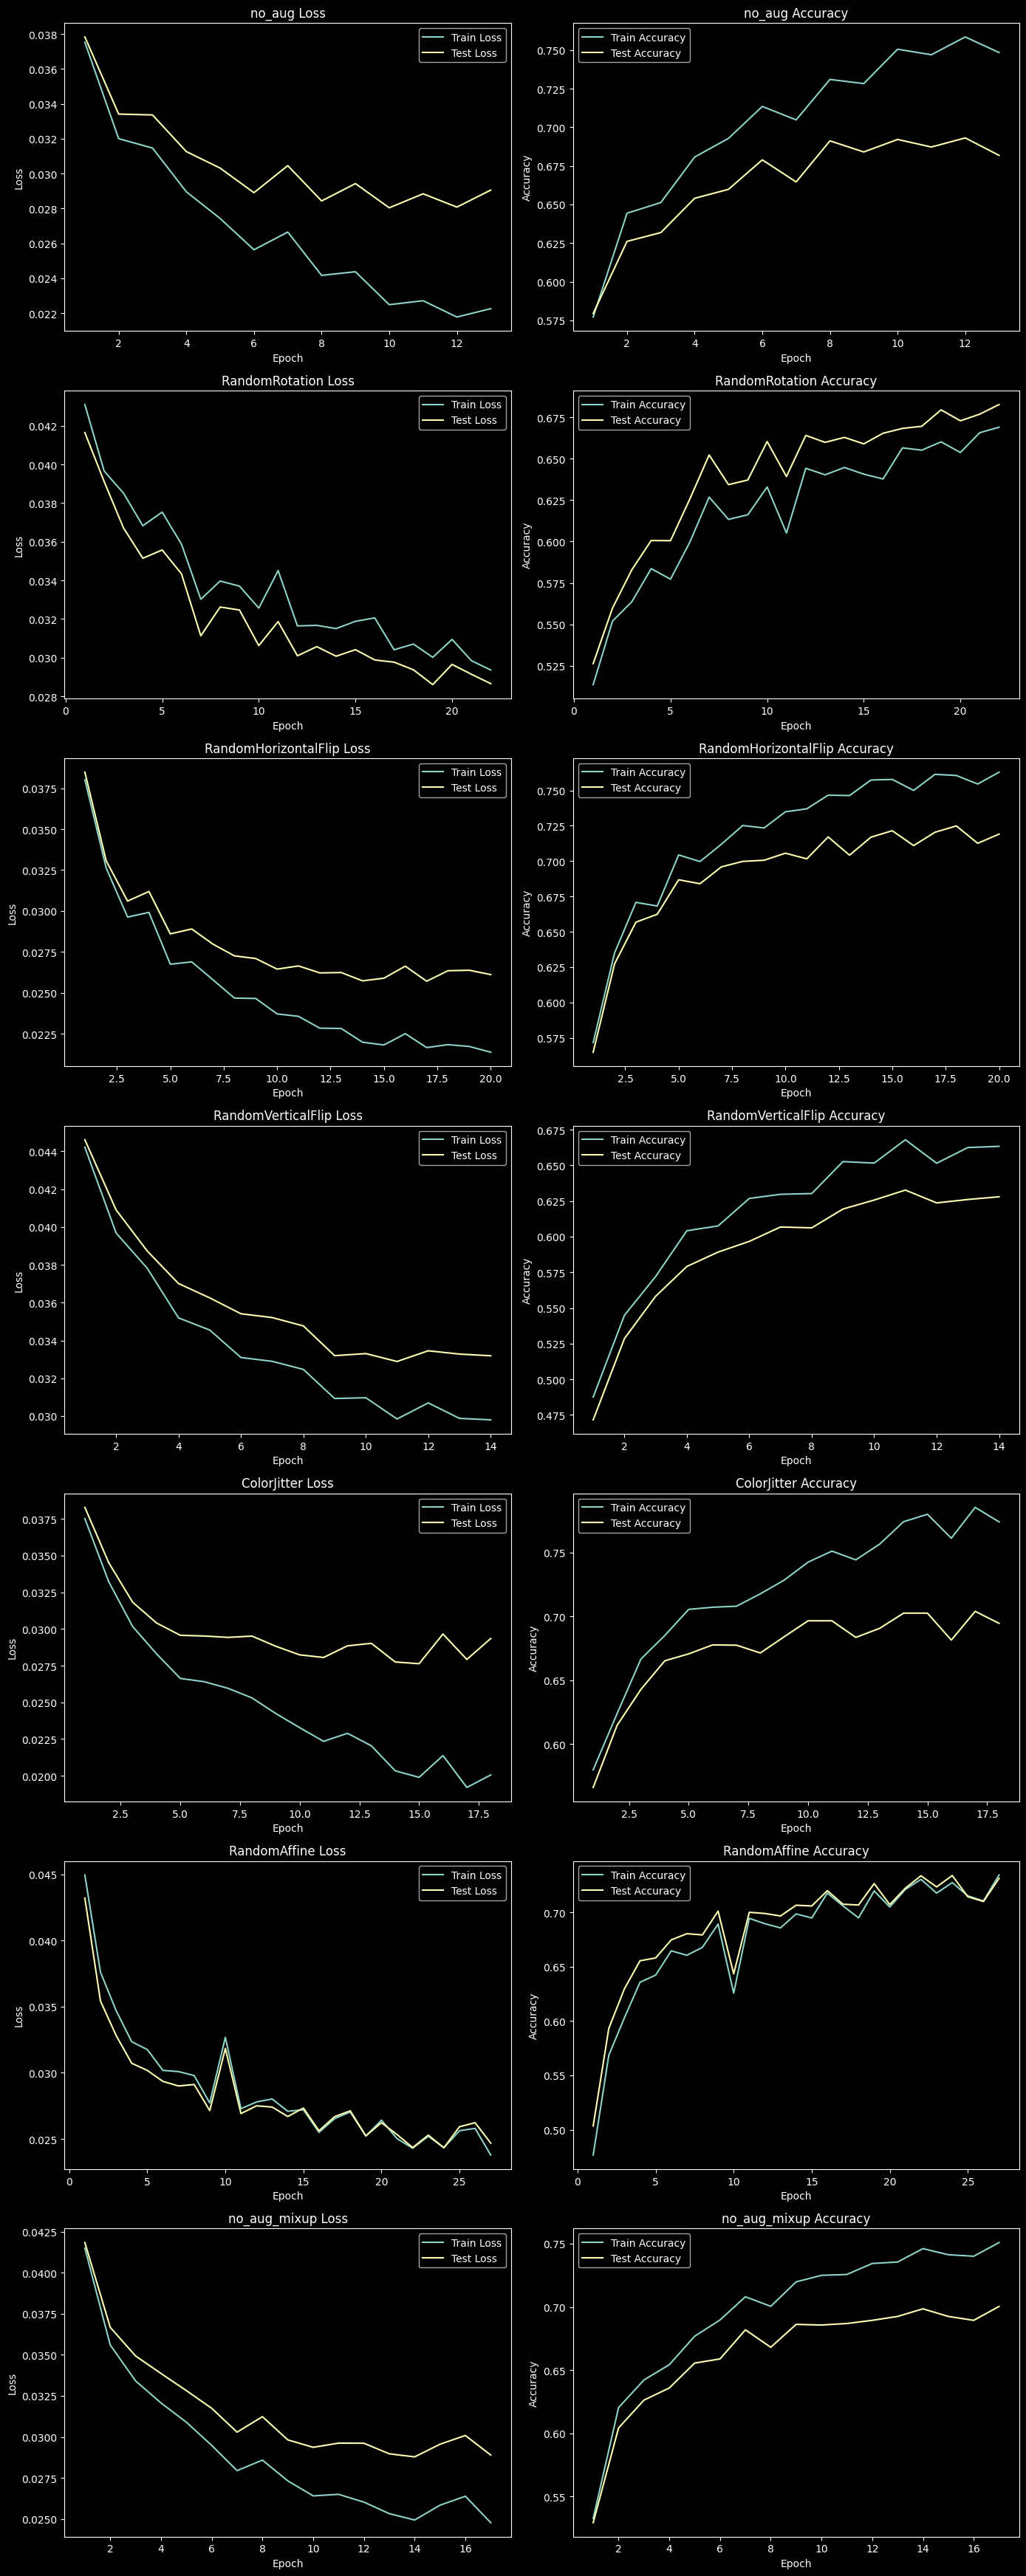

In [7]:

model = ThreeLayerCNN(32, 10).to(device)
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters())

transform = torchvision.transforms.ToTensor()

model = ThreeLayerCNN(32, 10).to(device)
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters())

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

print(f'\tTraining model without augmentation')
results['no_aug_mixup'] = fit(model, optimizer, loss_fn, train_dl, test_dl, epochs)
plot_results(results)



# Skrótowe połączenia

W kontekście sieci konwolucyjnych warto zpoznać się jeszcze z jedną istotną koncepcją: połączenia omijające warstwy, poprzez konkatenacje ich wyniku z wynikami dalszych warstw lub dodawanie ich wyniku do wyjścia dalszej warstwy (w drugim przypadku mówimy też o połączeniach *rezydualnych*). Połączenia takie są potrzebne szczególnie przy trenowaniu sieci bardzo głębokich, zawierających dziesiątki czy nawet ponad 100 warstw, czego nie będziemy w stanie realistycznie zrealizować w czasie naszych laboratoriów. Niemniej warto zapoznać się zarówno z samą ideą, jak i ich implementacją, jako że przy pracy z architekturami *state of the art* będziemy często natykać się na takie konstrukcje.

W konstrukcji sieci z połączeniamy pomijającymi warstwy i połączeniami rezydualnymi często będziemy spotykać się z powtarzalnymi *blokami* obejmującymi kilka warstw - dobrą praktyką implementacyjną jest wydzielanie takich bloków jako osobnych podklas `torch.nn.Module`. Warto też z góry zwrócić uwagę, że znane nam już `torch.nn.Sequential` nie uwzględnia połączeń innych niż sekwencyjne - czyli połączenia rezydualne i omijanie warstw nie wchodzi w grę, chyba że w obrębie wydzielonego bloku.

# Zadanie 3

Uzupełnij kod klasy SkipBlock tak, aby implementowała blok o zadanej strukturze.

Struktura SkipBlock:

główna sekwencja warstw

*   warstwa konwolucyjna, nie zmieniająca wymiarów szerokość/wysokość, `in_channels x out_channels`, filtr 3x3
*   aktywacja ReLU
*   warstwa konwolucyjna, wykonująca downsampling x2 w wymiarach szerokość/wysokość, filtr 3x3

warstwa poboczna (na wejściu: wejście do całego bloku, wyjście dodawane jest do wyjścia sekwencji powyżej)

*    warstwa konwolucyjna, filtr 2x2

**Samodzielnie dobierz niesprecyzowane parametry** tak, aby wymiary odpowiednich wyjść się zgadzały. Wyjście bloku powinno mieć `out_channels` kanałów oraz dwukrotnie zmniejszoną wysokość i szerokość w stosunku do wejścia.

In [8]:
from typing import List

class SkipBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.main_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=1)
        )
        self.skip_conv = nn.Conv2d(in_channels, out_channels, 2, stride=2)

        
    def forward(self,x):
        main_output = self.main_conv(x)
        skip_output = self.skip_conv(x)

        return main_output + skip_output



class SkipBlockCNN(torch.nn.Module):
    def __init__(self, channels: List[int], labels: int):
        super().__init__()
        self.model = torch.nn.Sequential()
        self.model.add_module("res_1", SkipBlock(3, channels[0]))
        self.model.add_module("relu_1", torch.nn.ReLU())
        self.model.add_module("res_2", SkipBlock(channels[0], channels[1]))
        self.model.add_module("relu_2", torch.nn.ReLU())
        self.model.add_module("res_3", SkipBlock(channels[1], channels[2]))
        self.model.add_module("relu_3", torch.nn.ReLU())
        self.model.add_module("flatten", torch.nn.Flatten())
        self.model.add_module("linear", torch.nn.Linear(4*4*channels[2], labels))
    
    def forward(self, x):
      return self.model(x)

 Wyucz sieć SkipBlockCNN i porównaj jej wyniki z wcześniej uzykanymi.

Files already downloaded and verified
Files already downloaded and verified
	Training model with SkipBlockCNN


100%|██████████| 1563/1563 [00:15<00:00, 98.45it/s] 


Epoch 0: train loss = 0.049 (acc: 0.449), test loss = 0.047 (acc: 0.463)


100%|██████████| 1563/1563 [00:14<00:00, 109.12it/s]


Epoch 1: train loss = 0.043 (acc: 0.511), test loss = 0.042 (acc: 0.524)


100%|██████████| 1563/1563 [00:14<00:00, 109.89it/s]


Epoch 2: train loss = 0.043 (acc: 0.531), test loss = 0.041 (acc: 0.543)


100%|██████████| 1563/1563 [00:14<00:00, 110.31it/s]


Epoch 3: train loss = 0.039 (acc: 0.566), test loss = 0.038 (acc: 0.584)


100%|██████████| 1563/1563 [00:14<00:00, 110.35it/s]


Epoch 4: train loss = 0.038 (acc: 0.583), test loss = 0.037 (acc: 0.595)


100%|██████████| 1563/1563 [00:14<00:00, 106.70it/s]


Epoch 5: train loss = 0.036 (acc: 0.604), test loss = 0.035 (acc: 0.623)


100%|██████████| 1563/1563 [00:14<00:00, 111.38it/s]


Epoch 6: train loss = 0.035 (acc: 0.614), test loss = 0.034 (acc: 0.620)


100%|██████████| 1563/1563 [00:13<00:00, 112.19it/s]


Epoch 7: train loss = 0.035 (acc: 0.616), test loss = 0.034 (acc: 0.622)


100%|██████████| 1563/1563 [00:14<00:00, 111.27it/s]


Epoch 8: train loss = 0.036 (acc: 0.600), test loss = 0.035 (acc: 0.614)


100%|██████████| 1563/1563 [00:14<00:00, 111.01it/s]


Epoch 9: train loss = 0.033 (acc: 0.643), test loss = 0.033 (acc: 0.649)


100%|██████████| 1563/1563 [00:14<00:00, 109.52it/s]


Epoch 10: train loss = 0.033 (acc: 0.639), test loss = 0.032 (acc: 0.655)


100%|██████████| 1563/1563 [00:14<00:00, 106.92it/s]


Epoch 11: train loss = 0.031 (acc: 0.660), test loss = 0.030 (acc: 0.673)


100%|██████████| 1563/1563 [00:14<00:00, 104.93it/s]


Epoch 12: train loss = 0.031 (acc: 0.665), test loss = 0.030 (acc: 0.680)


100%|██████████| 1563/1563 [00:14<00:00, 104.72it/s]


Epoch 13: train loss = 0.031 (acc: 0.669), test loss = 0.030 (acc: 0.683)


100%|██████████| 1563/1563 [00:14<00:00, 106.41it/s]


Epoch 14: train loss = 0.032 (acc: 0.660), test loss = 0.031 (acc: 0.663)


100%|██████████| 1563/1563 [00:14<00:00, 105.03it/s]


Epoch 15: train loss = 0.031 (acc: 0.677), test loss = 0.029 (acc: 0.688)


100%|██████████| 1563/1563 [00:14<00:00, 111.07it/s]


Epoch 16: train loss = 0.030 (acc: 0.675), test loss = 0.030 (acc: 0.683)


100%|██████████| 1563/1563 [00:14<00:00, 111.21it/s]


Epoch 17: train loss = 0.030 (acc: 0.681), test loss = 0.028 (acc: 0.698)


100%|██████████| 1563/1563 [00:14<00:00, 108.38it/s]


Epoch 18: train loss = 0.030 (acc: 0.673), test loss = 0.030 (acc: 0.679)


100%|██████████| 1563/1563 [00:14<00:00, 109.50it/s]


Epoch 19: train loss = 0.030 (acc: 0.692), test loss = 0.029 (acc: 0.696)


100%|██████████| 1563/1563 [00:14<00:00, 109.54it/s]


Epoch 20: train loss = 0.031 (acc: 0.676), test loss = 0.029 (acc: 0.688)
Interrupting training. No progress occurred during 3 epochs.


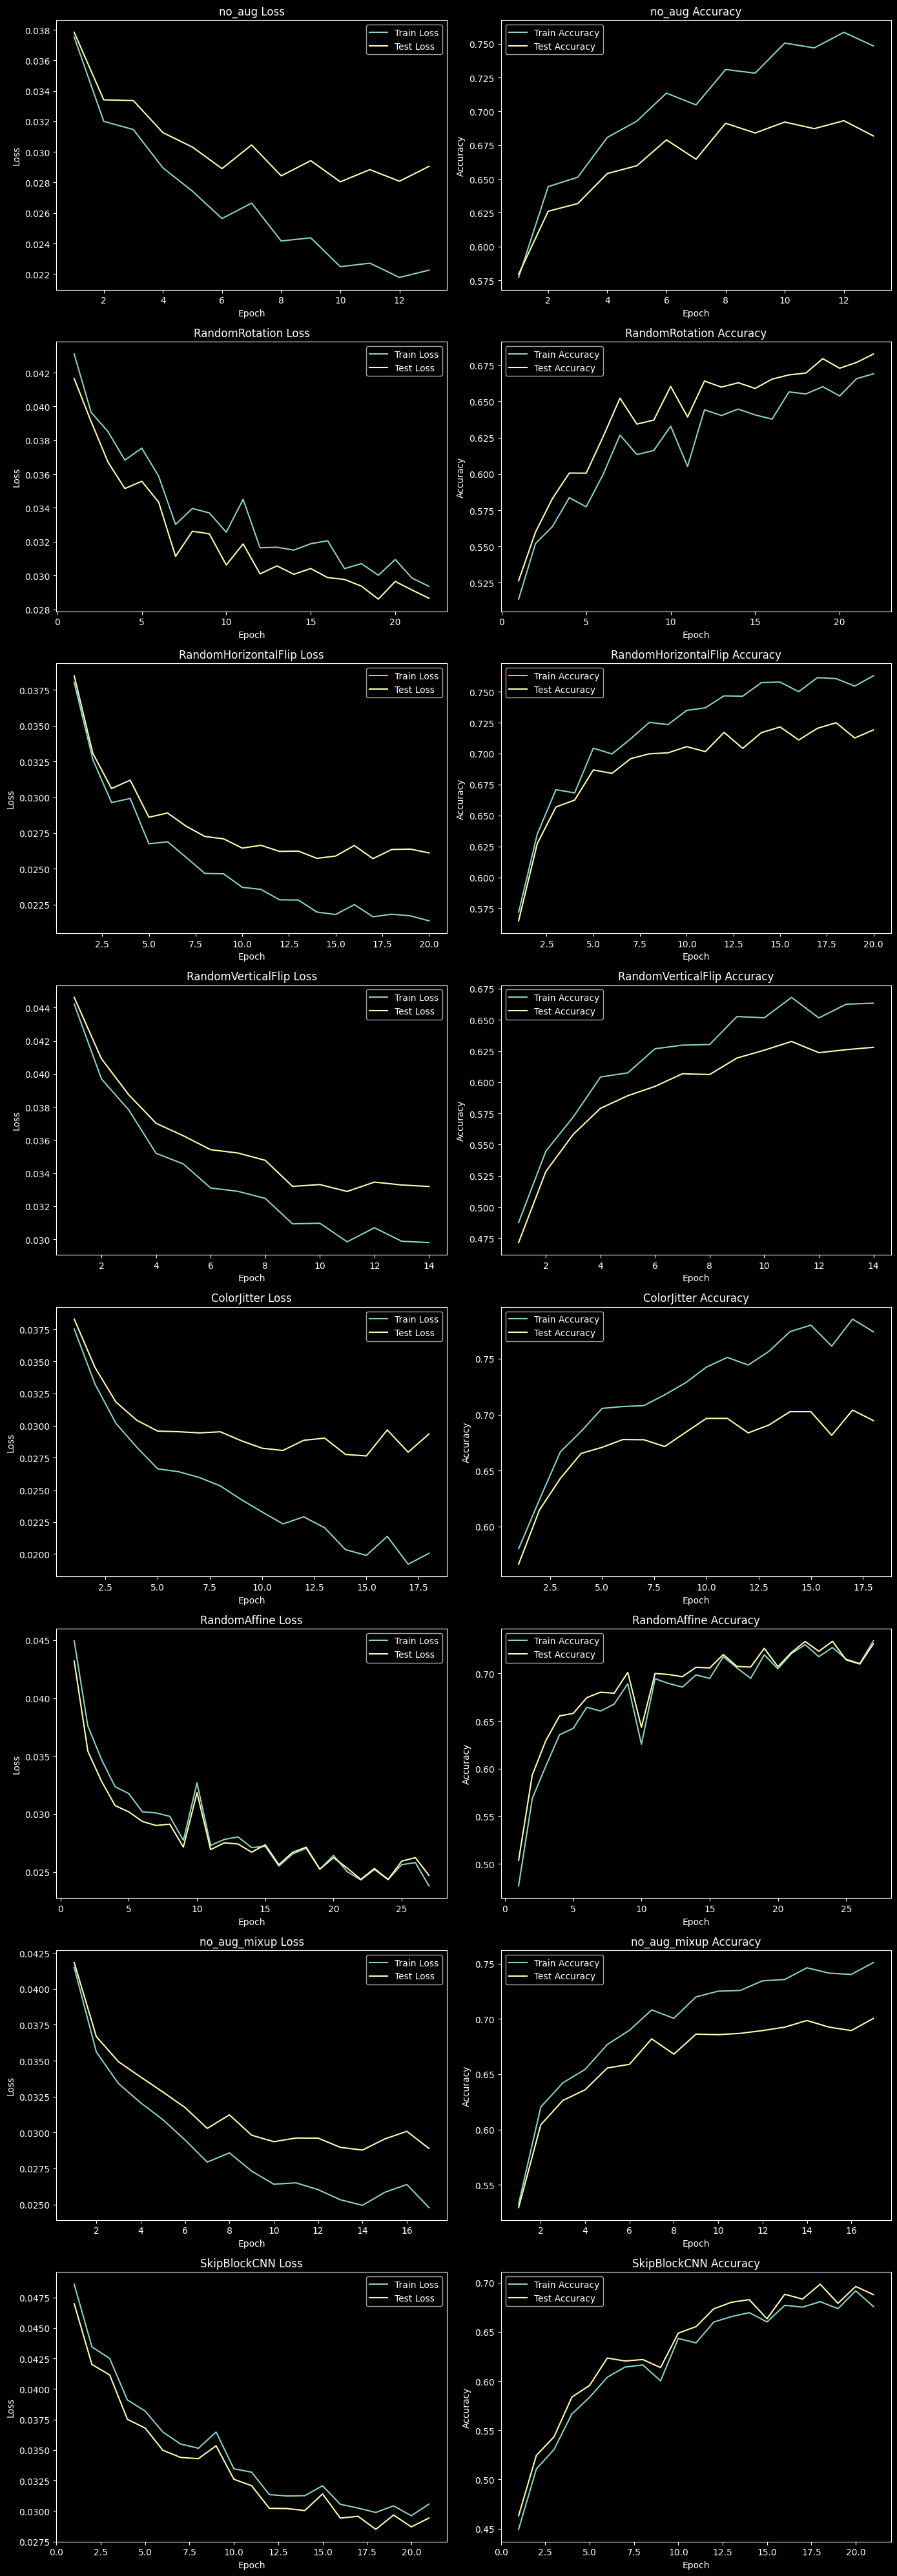

In [9]:
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

model = SkipBlockCNN([16,32,64], labels=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transforms.ToTensor(), train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

print(f'\tTraining model with SkipBlockCNN')
results['SkipBlockCNN'] = fit(model, optimizer, loss_fn, train_dl, test_dl, epochs)
plot_results(results)

In [10]:
# print(f'Results:')
# for key, value in results.items():
#     print(f'{key}:')
#     for k, v in value.items():
#         print(f'\t{k}: {v}')